<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Mads/AML_IceCores_parametric_umap_on_7th_trained_on_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
!pip install pyyaml h5py 
!pip install umap-learn

Streaming output truncated to the last 5000 lines.
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5532.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5533.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5534.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5535.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5536.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5537.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5538.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5539.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_554.png  
 extracting: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5540.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5541.png  
  inflating: Insoluables_T

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
from umap.parametric_umap import ParametricUMAP
import seaborn as sb
import lightgbm as lgb

In [3]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
sup = training_set(sup_df, sup_im_path)

In [4]:
# save image_size
im_e, _, _ = sup.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [5]:
# create encoder training
nr_tot_images = len(sup.labels)
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
rand_idx = np.arange(0,nr_tot_images)
rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
for i in range(nr_ims):
    im, lab, feat = sup.__getitem__(rand_idx[i])
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

In [6]:
x_train.shape

(10000, 128, 128)

In [7]:
latent_dim = 64
image_size= 128
unit_n = 32

encoder_input = keras.Input(shape=(image_size,image_size,1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu')(encoder_input)
x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(x)
x = keras.layers.Flatten()(x)
encoder_output = keras.layers.Dense(latent_dim)(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.InputLayer(input_shape=latent_dim)(encoder_output)
x = keras.layers.Dense(units=unit_n*unit_n*32, activation=tf.nn.relu)(decoder_input)
x = keras.layers.Reshape(target_shape=(unit_n, unit_n, 32))(x)
x = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
x = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
# No activation
decoder_output = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=1, padding='same')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

encoder.compile(opt, loss='mse')
autoencoder.compile(opt, loss='mse')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dense (Dense)               (None, 64)                3936320   
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 dense_1 (Dense)             (None, 32768)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

for i in range(1):
  # create encoder training
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 4000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  autoencoder.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

Epoch 1/200
113/113 [==============================] - 4s 32ms/step - loss: 0.0367 - val_loss: 0.0224
Epoch 2/200
113/113 [==============================] - 3s 30ms/step - loss: 0.0160 - val_loss: 0.0122
Epoch 3/200
113/113 [==============================] - 3s 30ms/step - loss: 0.0108 - val_loss: 0.0092
Epoch 4/200
113/113 [==============================] - 3s 30ms/step - loss: 0.0084 - val_loss: 0.0075
Epoch 5/200
113/113 [==============================] - 3s 30ms/step - loss: 0.0079 - val_loss: 0.0120
Epoch 6/200
113/113 [==============================] - 3s 29ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 7/200
113/113 [==============================] - 3s 29ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 8/200
113/113 [==============================] - 3s 31ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 9/200
113/113 [==============================] - 3s 30ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 10/200
113/113 [==============================] - 3s 30ms/step - loss: 0.004

In [16]:
encoder.save('encoder')

INFO:tensorflow:Assets written to: encoder/assets


In [17]:
y_preds = encoder.predict(x_train)

In [18]:
x_train_with_encoded = []
for i in range(len(y_preds)):
    inp = np.append(x_train_feats[i], y_preds[i])
    x_train_with_encoded.append(inp)
x_train_with_encoded = np.array(x_train_with_encoded)

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 98)]              0         
                                                                 
 dense_6 (Dense)             (None, 128)               12672     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/68 [==============================] - 2s 8ms/step - loss: 1.2216 - accuracy: 0.5846 - val_loss: 0.6362 - val_accuracy: 0.8017
Epoch 2/200
68/68 [==============================] - 0s 5ms/step - loss: 0.7643 - accuracy: 0.7217 - val_loss: 0.5562 - val_accuracy: 0.7975
Epoch 3/200
68/68 [==============================] - 0s 5ms/step - loss: 0.6532 - accuracy: 0.7557 - val_loss: 0.5452 - val_accuracy: 0.8140
Epoch 4/200
68/68 [==============================] - 0s 5ms/step - loss: 0.6072 - accuracy: 0.7640 - val_loss: 0.5088 - val_accuracy: 0.8017
Epoch 5/200
68/68 [==============================] - 0s 5ms/step - loss: 0.5519 - accuracy: 0.7806 - val_loss: 0.5063 - val_accuracy: 0.8140
Epoch 6/200
68/68 [==============================] - 0s 5ms/step - loss: 0.4919 - accuracy: 0.8077 - val_loss: 0.4814 - val_accuracy: 0.8306
Epoch 7/200
68/68 [==============================] - 0s 5ms/step - loss: 0.4862 - accuracy: 0.8142 - val_loss: 0.4483 - val_accuracy: 0.8182
Epoch 8/200
68/68 [======

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Epoch 1/10
785/785 [==============================] - 6s 5ms/step - loss: 0.1791
Epoch 2/10
785/785 [==============================] - 4s 5ms/step - loss: 0.1560
Epoch 3/10
785/785 [==============================] - 4s 5ms/step - loss: 0.1507
Epoch 4/10
785/785 [==============================] - 4s 5ms/step - loss: 0.1491
Epoch 5/10
785/785 [==============================] - 4s 5ms/step - loss: 0.1476
Epoch 6/10
785/785 [==============================] - 4s 5ms/step - loss: 0.1451
Epoch 7/10
785/785 [==============================] - 4s 5ms/step - loss: 0.1438
Epoch 8/10
785/785 [==============================] - 4s 5ms/step - loss: 0.1435
Epoch 9/10
785/785 [==============================] - 4s 6ms/step - loss: 0.1428
Epoch 10/10
785/785 [==============================] - 5s 6ms/step - loss: 0.1415
Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None,

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


107/107 [==============================] - 2s 7ms/step - loss: 1.2506 - accuracy: 0.5870 - val_loss: 0.7602 - val_accuracy: 0.7684
Epoch 2/200
107/107 [==============================] - 1s 5ms/step - loss: 0.8388 - accuracy: 0.7141 - val_loss: 0.6371 - val_accuracy: 0.7895
Epoch 3/200
107/107 [==============================] - 1s 5ms/step - loss: 0.7561 - accuracy: 0.7414 - val_loss: 0.5725 - val_accuracy: 0.7974
Epoch 4/200
107/107 [==============================] - 1s 5ms/step - loss: 0.7040 - accuracy: 0.7566 - val_loss: 0.5496 - val_accuracy: 0.8158
Epoch 5/200
107/107 [==============================] - 1s 5ms/step - loss: 0.6582 - accuracy: 0.7633 - val_loss: 0.5604 - val_accuracy: 0.7921
Epoch 6/200
107/107 [==============================] - 1s 5ms/step - loss: 0.6172 - accuracy: 0.7698 - val_loss: 0.5321 - val_accuracy: 0.8079
Epoch 7/200
107/107 [==============================] - 1s 5ms/step - loss: 0.5933 - accuracy: 0.7809 - val_loss: 0.5373 - val_accuracy: 0.8079
Epoch 8/200

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


88/88 [==============================] - 2s 8ms/step - loss: 1.3339 - accuracy: 0.5666 - val_loss: 0.7235 - val_accuracy: 0.7564
Epoch 2/200
88/88 [==============================] - 0s 5ms/step - loss: 0.9339 - accuracy: 0.6770 - val_loss: 0.6502 - val_accuracy: 0.7853
Epoch 3/200
88/88 [==============================] - 0s 5ms/step - loss: 0.8379 - accuracy: 0.7149 - val_loss: 0.6449 - val_accuracy: 0.7756
Epoch 4/200
88/88 [==============================] - 0s 5ms/step - loss: 0.7859 - accuracy: 0.7245 - val_loss: 0.6407 - val_accuracy: 0.7692
Epoch 5/200
88/88 [==============================] - 0s 5ms/step - loss: 0.7263 - accuracy: 0.7446 - val_loss: 0.5859 - val_accuracy: 0.7788
Epoch 6/200
88/88 [==============================] - 0s 5ms/step - loss: 0.6987 - accuracy: 0.7463 - val_loss: 0.5857 - val_accuracy: 0.7885
Epoch 7/200
88/88 [==============================] - 0s 5ms/step - loss: 0.6537 - accuracy: 0.7671 - val_loss: 0.6158 - val_accuracy: 0.7756
Epoch 8/200
88/88 [======

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


101/101 [==============================] - 2s 7ms/step - loss: 1.1399 - accuracy: 0.6344 - val_loss: 0.5505 - val_accuracy: 0.8128
Epoch 2/200
101/101 [==============================] - 1s 5ms/step - loss: 0.6996 - accuracy: 0.7604 - val_loss: 0.4795 - val_accuracy: 0.8464
Epoch 3/200
101/101 [==============================] - 1s 5ms/step - loss: 0.5868 - accuracy: 0.7877 - val_loss: 0.4651 - val_accuracy: 0.8380
Epoch 4/200
101/101 [==============================] - 1s 5ms/step - loss: 0.5407 - accuracy: 0.7976 - val_loss: 0.4287 - val_accuracy: 0.8352
Epoch 5/200
101/101 [==============================] - 1s 5ms/step - loss: 0.5174 - accuracy: 0.7952 - val_loss: 0.4649 - val_accuracy: 0.8324
Epoch 6/200
101/101 [==============================] - 1s 5ms/step - loss: 0.4776 - accuracy: 0.8194 - val_loss: 0.4396 - val_accuracy: 0.8547
Epoch 7/200
101/101 [==============================] - 1s 5ms/step - loss: 0.4430 - accuracy: 0.8340 - val_loss: 0.4300 - val_accuracy: 0.8436
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


105/105 [==============================] - 2s 7ms/step - loss: 1.2371 - accuracy: 0.6038 - val_loss: 0.5910 - val_accuracy: 0.8329
Epoch 2/200
105/105 [==============================] - 1s 5ms/step - loss: 0.7876 - accuracy: 0.7513 - val_loss: 0.5014 - val_accuracy: 0.8464
Epoch 3/200
105/105 [==============================] - 1s 5ms/step - loss: 0.7052 - accuracy: 0.7642 - val_loss: 0.5042 - val_accuracy: 0.8491
Epoch 4/200
105/105 [==============================] - 1s 5ms/step - loss: 0.6362 - accuracy: 0.7876 - val_loss: 0.4610 - val_accuracy: 0.8571
Epoch 5/200
105/105 [==============================] - 1s 5ms/step - loss: 0.6053 - accuracy: 0.7984 - val_loss: 0.4648 - val_accuracy: 0.8571
Epoch 6/200
105/105 [==============================] - 1s 5ms/step - loss: 0.5561 - accuracy: 0.8074 - val_loss: 0.4645 - val_accuracy: 0.8518
Epoch 7/200
105/105 [==============================] - 0s 5ms/step - loss: 0.5263 - accuracy: 0.8197 - val_loss: 0.4823 - val_accuracy: 0.8410
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


105/105 [==============================] - 2s 7ms/step - loss: 1.2349 - accuracy: 0.6041 - val_loss: 0.6310 - val_accuracy: 0.8329
Epoch 2/200
105/105 [==============================] - 1s 5ms/step - loss: 0.8037 - accuracy: 0.7498 - val_loss: 0.5256 - val_accuracy: 0.8356
Epoch 3/200
105/105 [==============================] - 1s 5ms/step - loss: 0.6801 - accuracy: 0.7785 - val_loss: 0.5418 - val_accuracy: 0.8410
Epoch 4/200
105/105 [==============================] - 1s 5ms/step - loss: 0.6321 - accuracy: 0.7872 - val_loss: 0.4934 - val_accuracy: 0.8383
Epoch 5/200
105/105 [==============================] - 1s 5ms/step - loss: 0.5985 - accuracy: 0.7992 - val_loss: 0.5039 - val_accuracy: 0.8356
Epoch 6/200
105/105 [==============================] - 1s 5ms/step - loss: 0.5464 - accuracy: 0.8115 - val_loss: 0.4627 - val_accuracy: 0.8571
Epoch 7/200
105/105 [==============================] - 1s 5ms/step - loss: 0.5384 - accuracy: 0.8160 - val_loss: 0.4246 - val_accuracy: 0.8598
Epoch 8/200

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


104/104 [==============================] - 2s 7ms/step - loss: 1.1524 - accuracy: 0.6262 - val_loss: 0.4711 - val_accuracy: 0.8401
Epoch 2/200
104/104 [==============================] - 1s 5ms/step - loss: 0.6808 - accuracy: 0.7850 - val_loss: 0.3697 - val_accuracy: 0.8699
Epoch 3/200
104/104 [==============================] - 1s 5ms/step - loss: 0.5758 - accuracy: 0.8089 - val_loss: 0.3682 - val_accuracy: 0.8645
Epoch 4/200
104/104 [==============================] - 1s 5ms/step - loss: 0.5168 - accuracy: 0.8188 - val_loss: 0.3311 - val_accuracy: 0.8862
Epoch 5/200
104/104 [==============================] - 1s 5ms/step - loss: 0.4810 - accuracy: 0.8297 - val_loss: 0.3235 - val_accuracy: 0.8808
Epoch 6/200
104/104 [==============================] - 1s 5ms/step - loss: 0.4683 - accuracy: 0.8366 - val_loss: 0.3113 - val_accuracy: 0.8916
Epoch 7/200
104/104 [==============================] - 0s 5ms/step - loss: 0.4332 - accuracy: 0.8447 - val_loss: 0.3323 - val_accuracy: 0.8862
Epoch 8/200

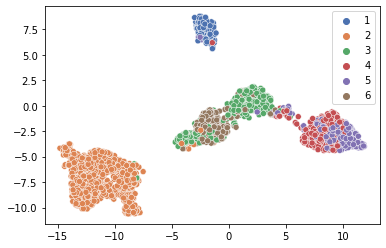

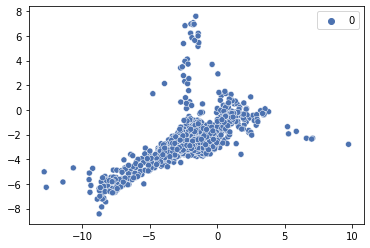

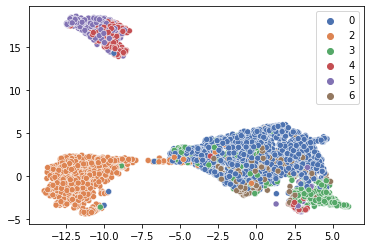

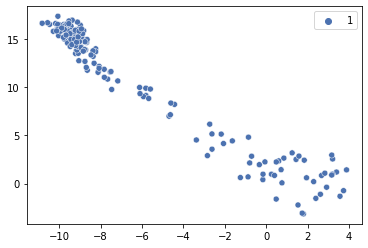

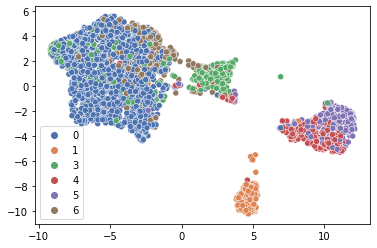

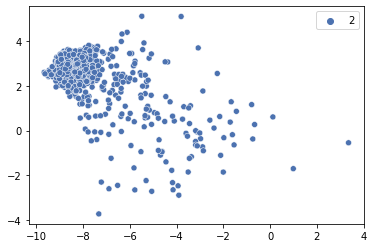

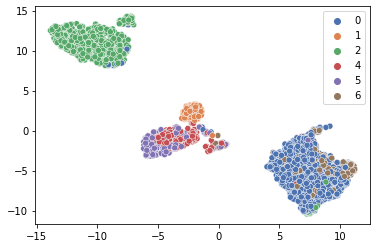

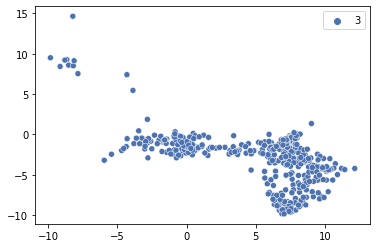

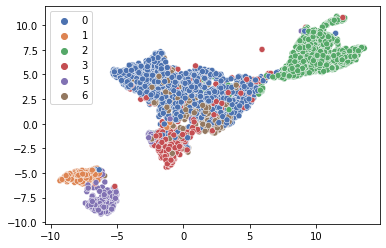

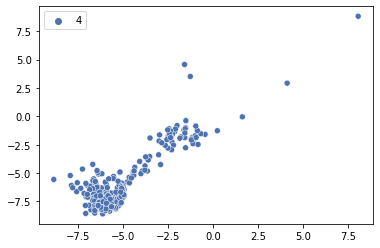

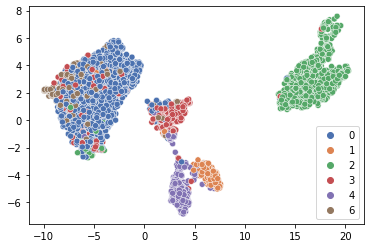

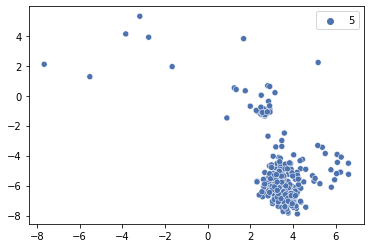

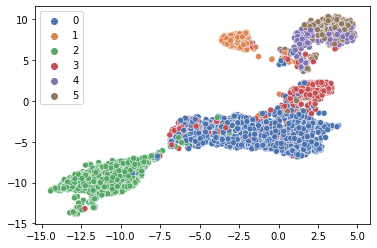

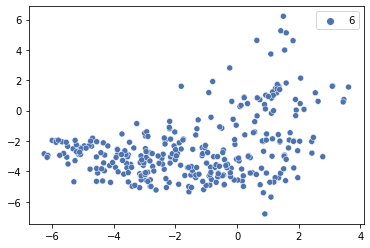

In [19]:
for i in range(7):
  data_use = x_train_with_encoded[x_train_lab!=i]
  labels_use = x_train_lab[x_train_lab!=i]
  data_extra = x_train_with_encoded[x_train_lab==i]
  labels_extra = x_train_lab[x_train_lab==i]


  input_length = len(x_train_feats[0]) + latent_dim

  dense_input = keras.Input(shape=(input_length))
  x = keras.layers.Dense(128, activation='relu')(dense_input)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  x = keras.layers.Dense(128*2, activation='relu')(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  dense_middle = keras.layers.Dense(128, activation='relu')(x)

  nn_last_hidden = keras.Model(dense_input, dense_middle, name='nn_last_hidden')

  dense_new_input = keras.layers.InputLayer(input_shape=128)(dense_middle)
  x = keras.layers.Dropout(0.2)(dense_new_input)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  dense_output = keras.layers.Dense(7, activation='softmax')(x)

  nn_model = keras.Model(dense_input, dense_output, name='dense_model')

  nn_model.summary()

  opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

  nn_last_hidden.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
  nn_model.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

  nn_model.fit(data_use, labels_use, batch_size=32, epochs=200, validation_split=0.1, callbacks=[callback])

  last_hidden_vals = nn_last_hidden.predict(data_use) #x_train_feats[i], y_preds[i], x_train_with_encoded

  map = ParametricUMAP(n_components=2)#, n_neighbors=8, min_dist=0.05)
  y = map.fit_transform(last_hidden_vals)

  plt.figure()
  sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = labels_use, palette='deep')

  last_hidden_vals = nn_last_hidden.predict(data_extra)
  y = map.transform(last_hidden_vals)

  plt.figure()
  sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = labels_extra, palette='deep')
plt.show()

In [20]:
x_train_lab

array([0, 0, 0, ..., 4, 2, 2])